In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
a = np.arange(-5,5,0.25)

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
a

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

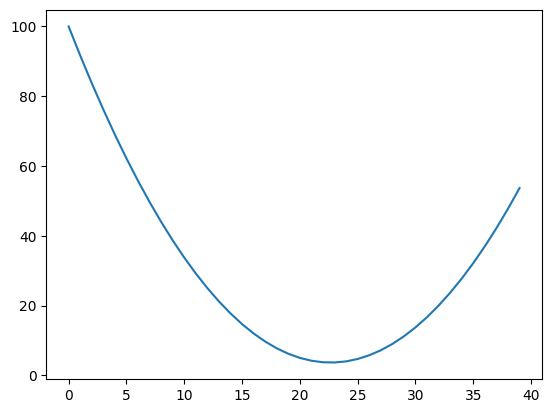

In [ ]:
plt.plot(f(a))

In [ ]:
h = 0.001
x = 3.0
(f(x+h) - f(x))/h

14.00300000000243

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d  = a*b+c
print(d)

4.0


In [ ]:
h = 0.0001
d1 = a*b + c
a += h
d2 = a*b + c

In [ ]:
print(d1,d2,(d2-d1)/h)

4.0 3.999699999999999 -3.000000000010772


In [ ]:
class Value:
  def __init__(self, data,_children=(), _op='', label=''):
    self.data = data
    self._op = _op
    self.grad = 0
    self._prev = set(_children)
    self.label = label
    self._backward = lambda: None
  def __repr__(self):
    return f"Value(data={self.data})"
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self,other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out
  def __radd__(self, other):
    return self + other
  def __rmul__(self, other):
    return self * other
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad = out.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self, ), f'**{other}')
    def _backward():
      self.grad = other ** (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out
  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1
  def __sub__(self, other):
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad += (1-t**2) * out.grad
    out._backward = _backward
    return out
  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()





In [ ]:
def lol():
  h = 0.001
  a = Value(2.0, label='a')
  b = Value(3.0, label='b')
  c = Value(2.0, label='c')
  d = a + b; d.label = 'd'
  e = d * c; e.label = 'e'
  L1 = e.data

  a = Value(2.0, label='a')
  b = Value(3.0, label='b')
  c = Value(2.0 + h, label='c')
  d = a + b; d.label = 'd'
  e = d * c; e.label = 'e'
  L2 = e.data
  print((L2-L1)/h)

lol()

4.999999999999005


In [ ]:
from graphviz import Digraph
def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uuid = str(id(n))
    dot.node(name=uuid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')

    if n._op:
      dot.node(name=uuid + n._op, label = n._op)
      dot.edge(uuid + n._op, uuid)
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot

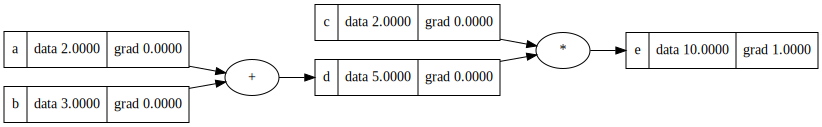

In [ ]:
draw_dot(e)

In [ ]:
e.grad = 1

In [ ]:
#input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o  = n.tanh(); o.label = 'o'


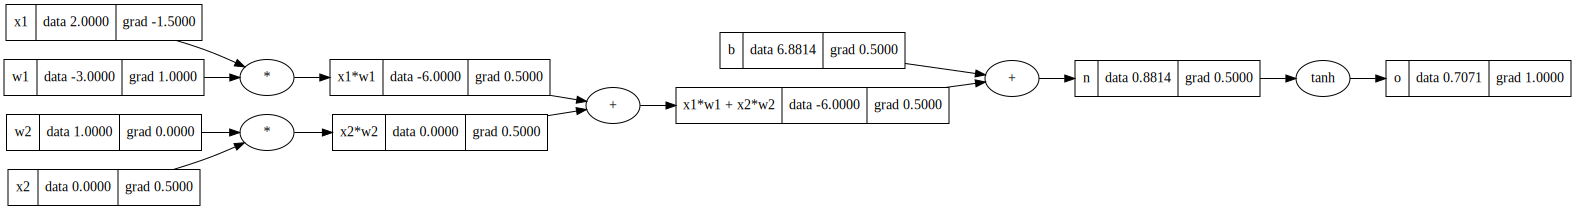

In [ ]:
draw_dot(o)

In [ ]:
o.backward()

In [ ]:
o.grad = 1
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)


for node in reversed(topo):
  node._backward()

In [ ]:
o.grad = 1
o._backward()


In [ ]:
n._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
x2w2._backward()

In [ ]:
x1w1._backward()

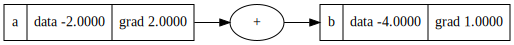

In [ ]:
a = Value(-2.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [ ]:
a = Value(2.0)
b = Value(2.0)
a - b

Value(data=0.0)